In [25]:
import numpy as np
import os
from pprint import pprint
from collections import defaultdict
import seq_helper as seqh
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from matplotlib.cm import spectral
import matplotlib.pyplot as plt

In [18]:
# read data
dirname = ''.join(['./pre_process_dataset/'])
file_list = []
fm_set = set()
Q_set = set()
label = []

name_image_dict = {}
for name in os.listdir(dirname):    
    file_path_name = ''.join(['./pre_process_dataset/',name])    
    data = (seqh.read_from_file(file_path_name))   
    
    Q_hist = set(data[0].keys())        
    Q_set.update(Q_hist)    
        
    fm = data[1].keys()
    fm_set.update(set(fm))
    
    label.append(data[2])
    
    file_list.append(data)

label = np.array(label)

In [19]:
# format data into matrix
data_num = len(file_list)

Q_dim = len(Q_set)
Q_index = [i for i in range(Q_dim)]
Q_name = list(Q_set)
Q_name_index_dict = dict(zip(Q_name, Q_index))

fm_dim = len(fm_set)
fm_index = [i for i in range(fm_dim)]  #for the dict to matrix mapping
fm_name = list(fm_set)
fm_name_index_dict = dict(zip(fm_name, fm_index))

Q = np.zeros((data_num, Q_dim))    #Q quality matrix, shape num_data, dim
F = np.zeros((data_num, fm_dim))   #4-mer matrix, shape num_data, dim

for i in range(data_num):
    data = file_list[i]
    Q_hist = data[0]
    fm_hist = data[1]
    data_Q_num = np.sum(np.array(list(Q_hist.values())))
    data_fm_num = np.sum(np.array(list(fm_hist.values())))    
    
    for key, value in Q_hist.items():
        j = Q_name_index_dict[key]
        Q[i,j] = value/data_Q_num       #normalization
        
    for key, value in fm_hist.items():
        j = fm_name_index_dict[key]
        F[i,j] = value/data_fm_num      #normalization
    

In [20]:
# logistic regression, 0.6 training, 0.2 validation, 0.2 testing
Q_train, Q_test, F_train, F_test, label_train, label_test=train_test_split(Q,F,label,test_size=0.4, random_state=42)
Q_valid, Q_test, F_valid, F_test, label_valid, label_test=train_test_split(Q_test,F_test,label_test,test_size=0.5, 
                                                                           random_state=42)

C = 100000000000 # large C -> no regularization
logistic_regr = LogisticRegression(penalty='l2', C=C) 

val_pred_list = []
logistic_regr.fit(Q_train, label_train)

# on validation set    
valid_pred = (logistic_regr.predict(Q_valid))
valid_pred_l = list((valid_pred.astype('float')).astype('int'))
label_valid_l = list((label_valid.astype('float')).astype('int'))

seqh.evaluate_result(label_valid_l, valid_pred_l)

accuracy:  0.888888888889
precision:  0.909090909091
recall:  0.857142857143
[[30  5]
 [ 3 34]]


In [21]:
# on test set    
test_pred = (logistic_regr.predict(Q_test))
test_pred_l = list((test_pred.astype('float')).astype('int'))
label_test_l = list((label_test.astype('float')).astype('int'))
seqh.evaluate_result(label_test_l, test_pred_l)

accuracy:  0.833333333333
precision:  0.837837837838
recall:  0.837837837838
[[31  6]
 [ 6 29]]


In [22]:
C = 100000000000 # large C -> no regularization
logistic_regr = LogisticRegression(penalty='l2', C=C) 

val_pred_list = []
logistic_regr.fit(F_train, label_train)

# on validation set    
valid_pred = (logistic_regr.predict(F_valid))
valid_pred_l = list((valid_pred.astype('float')).astype('int'))
label_valid_l = list((label_valid.astype('float')).astype('int'))

seqh.evaluate_result(label_valid_l, valid_pred_l)

accuracy:  0.958333333333
precision:  1.0
recall:  0.914285714286
[[32  3]
 [ 0 37]]


In [23]:
# on test set    
test_pred = (logistic_regr.predict(F_test))
test_pred_l = list((test_pred.astype('float')).astype('int'))
label_test_l = list((label_test.astype('float')).astype('int'))
seqh.evaluate_result(label_test_l, test_pred_l)

accuracy:  0.972222222222
precision:  1.0
recall:  0.945945945946
[[35  2]
 [ 0 35]]


(359, 35) (359, 2) (2, 35)


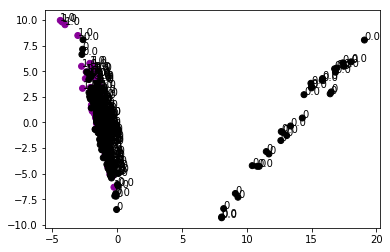

In [31]:
x = Q

mean_x = np.mean(x, axis=0)
std_x = np.std(x, axis=0)
x_standard = (x-mean_x)/std_x
pca = PCA(n_components=2).fit(x_standard)
projected_x = pca.transform(x_standard)
print(x_standard.shape, projected_x.shape, pca.components_.shape)

#for i in label draw
fig, ax = plt.subplots()

c=[spectral(float(i) /10) for i in label]
ax.scatter(projected_x[:,0],projected_x[:,1], c=c)
txt = [str(i) for i in label] #[label_text_dict[i] for i in label]
for i in range(x.shape[0]):
    ax.annotate(txt[i], (projected_x[i,0],projected_x[i,1]),size=10)

plt.show()

In [14]:
# save data
F_name = 'F_with_N.csv'
Q_name = 'Q.csv'
L_name = 'L.csv'
F_save = ''.join(['./matrix_data/', F_name])
np.savetxt(F_save, F, delimiter=",")
Q_save = ''.join(['./matrix_data/', Q_name])
np.savetxt(Q_save, Q, delimiter=",")
L_save = ''.join(['./matrix_data/', L_name])
L = np.array(label).astype(np.float)
np.savetxt(L_save, L, delimiter=",")